<a href="https://colab.research.google.com/github/iangreene/ECE50024_FinalProject/blob/main/ECE50024_FinalProject_Method_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm
import concurrent.futures
import warnings

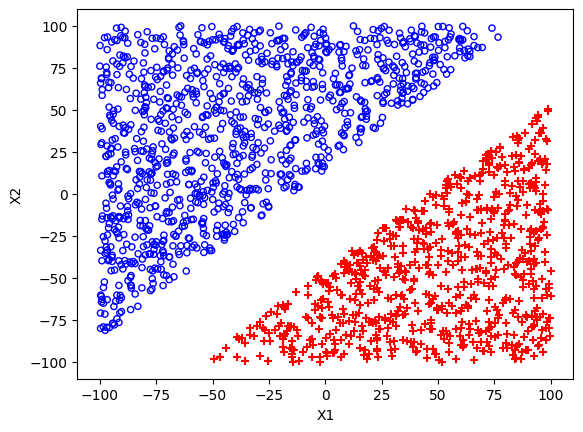

In [91]:
# Dataset Creation and Plotting
COLOR = {-1: 'b', 1: 'r'}
MARKER = {-1: 'o', 1: '+'}
FACE = {-1: 'none', 1: 'r'}
SIZE = {-1: 20, 1: 40}

N = 2500
buffer_size = 100

np.random.seed(0)
X = np.random.uniform(low=-buffer_size, high=buffer_size, size=(N, 2))

margin = -0.15*buffer_size
buffer_zone = 0.3*buffer_size

y = np.zeros(N)
for i in range(N):
    if X[i, 0] <= X[i, 1] - margin - buffer_zone:
        y[i] = -1
    elif X[i, 0] >= X[i, 1] - margin + buffer_zone:
        y[i] = 1

X_labeled = X[y != 0]
y_labeled = y[y != 0]

for label in [-1, 1]:
    mask = (y_labeled == label)
    plt.scatter(X_labeled[mask, 0], X_labeled[mask, 1], s=SIZE[label], facecolors=FACE[label], edgecolors=COLOR[label], marker=MARKER[label])
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

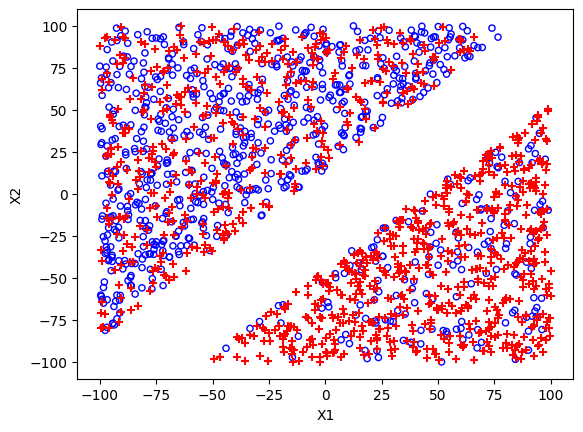

In [92]:
# Making Data Noisy and Plotting
rho_plus = 0.2
rho_minus = 0.4

y_noisy = np.copy(y_labeled)
for i in range(len(y_noisy)):
    if y_labeled[i] == 1:
        if np.random.random() < rho_plus:
            y_noisy[i] = -1
    elif y_labeled[i] == -1:
        if np.random.random() < rho_minus:
            y_noisy[i] = 1

for label in [-1, 1]:
    mask = (y_noisy == label)
    plt.scatter(X_labeled[mask, 0], X_labeled[mask, 1], s=SIZE[label], facecolors=FACE[label], edgecolors=COLOR[label], marker=MARKER[label])
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [93]:
# Implementation of Method of Unbiased Estimators with Known Noise
def logistic_loss(t, y):
    return np.log(1 + np.exp(-t * y))

def unbiased_loss(t, y, rho_plus, rho_minus):
    rho_y = (y + 1) / 2 * (rho_plus - rho_minus) + rho_minus
    rho_minus_y = (y + 1) / 2 * (rho_minus - rho_plus) + rho_plus
    return ((1 - rho_minus_y) * logistic_loss(t, y) - rho_y * logistic_loss(t, -y)) / (1 - rho_plus - rho_minus)

def average_loss(params, X, y, rho_plus, rho_minus):
    t = np.dot(X, params)
    unbiased_losses = unbiased_loss(t, y, rho_plus, rho_minus)
    return np.mean(unbiased_losses)

def find_best_params(X, y, rho_plus, rho_minus):
    init_params = np.zeros(X.shape[1])
    result = minimize(average_loss, init_params, args=(X, y, rho_plus, rho_minus))
    return result.x

best_params = find_best_params(X_labeled, y_noisy, rho_plus, rho_minus)

In [94]:
print(best_params)

[ 0.04512671 -0.04798343]


In [95]:
def predict(X, params):
    scores = np.dot(X, params)
    return np.sign(scores)

y_pred = predict(X_labeled, best_params)

1.0


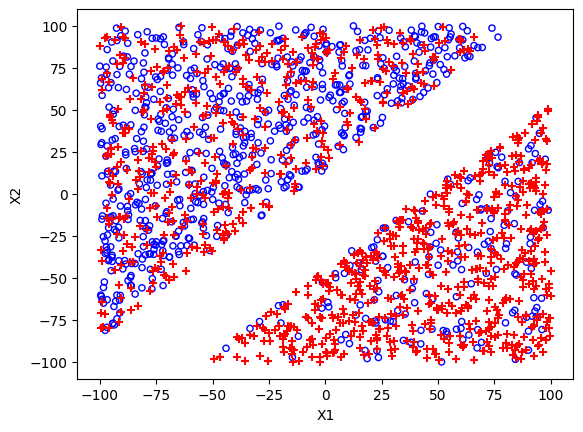

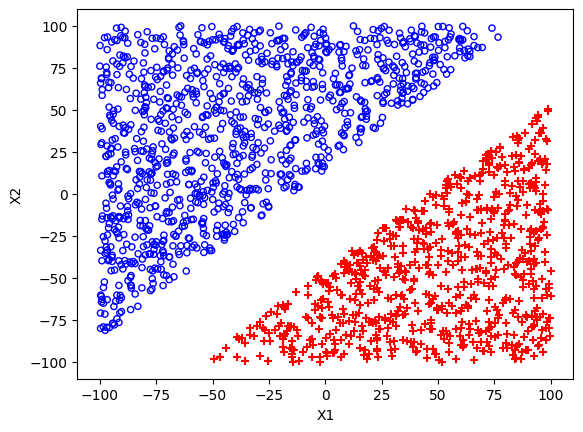

In [96]:
# Plotting and Accuracy for Method of Unbiased Estimators with Known Noise Rates
print(accuracy_score(y_labeled, y_pred))

for label in [-1, 1]:
    mask = (y_noisy == label)
    plt.scatter(X_labeled[mask, 0], X_labeled[mask, 1], s=SIZE[label], facecolors=FACE[label], edgecolors=COLOR[label], marker=MARKER[label])
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

for label in [-1, 1]:
    mask = (y_pred == label)
    plt.scatter(X_labeled[mask, 0], X_labeled[mask, 1], s=SIZE[label], facecolors=FACE[label], edgecolors=COLOR[label], marker=MARKER[label])
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [97]:
# Baseline using normal Logistic Regression
clf = LogisticRegression()
clf.fit(X_labeled, y_noisy)

y_pred = clf.predict(X_labeled)

acc = accuracy_score(y_labeled, y_pred)
print('Accuracy:', acc)

Accuracy: 0.8308026030368764


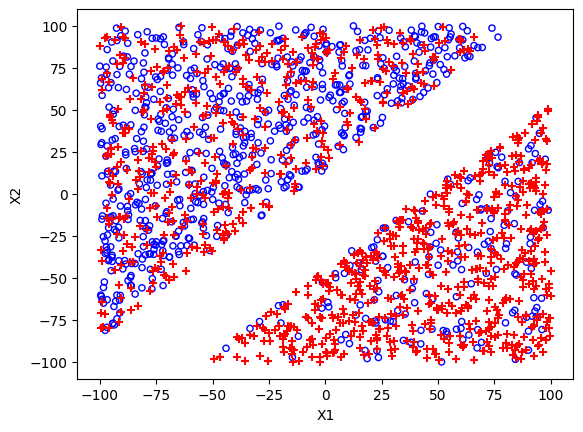

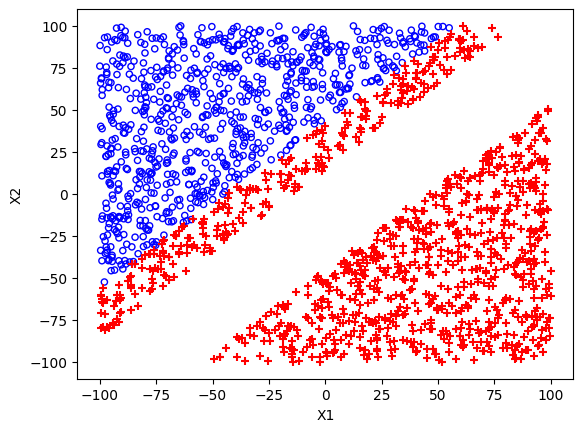

In [98]:
for label in [-1, 1]:
    mask = (y_noisy == label)
    plt.scatter(X_labeled[mask, 0], X_labeled[mask, 1], s=SIZE[label], facecolors=FACE[label], edgecolors=COLOR[label], marker=MARKER[label])
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

for label in [-1, 1]:
    mask = (y_pred == label)
    plt.scatter(X_labeled[mask, 0], X_labeled[mask, 1], s=SIZE[label], facecolors=FACE[label], edgecolors=COLOR[label], marker=MARKER[label])
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [99]:
# Implementation of Method of Unbiased Estimators with Unknown Noise Rates
warnings.filterwarnings("ignore")

def logistic_loss(t, y):
    return np.log(1 + np.exp(-t * y))

def unbiased_loss(t, y, rho_plus, rho_minus):
    rho_y = (y + 1) / 2 * (rho_plus - rho_minus) + rho_minus
    rho_minus_y = (y + 1) / 2 * (rho_minus - rho_plus) + rho_plus
    return ((1 - rho_minus_y) * logistic_loss(t, y) - rho_y * logistic_loss(t, -y)) / (1 - rho_plus - rho_minus)

def average_loss(params, X, y, rho_plus, rho_minus):
    t = np.dot(X, params)
    unbiased_losses = unbiased_loss(t, y, rho_plus, rho_minus)
    return np.mean(unbiased_losses)

def find_best_params(X, y, rho_plus, rho_minus):
    init_params = np.zeros(X.shape[1])
    result = minimize(average_loss, init_params, args=(X, y, rho_plus, rho_minus))
    return result.x

def single_fold(train_index, test_index, X, y, rho_plus, rho_minus):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    best_params = find_best_params(X_train, y_train, rho_plus, rho_minus)
    fold_loss = average_loss(best_params, X_train, y_train, rho_plus, rho_minus)
    return fold_loss

def k_fold_cross_validation(X, y, rho_plus, rho_minus, k=5):
    kf = KFold(n_splits=k)
    fold_results = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(single_fold, train_index, test_index, X, y, rho_plus, rho_minus)
                   for train_index, test_index in kf.split(X)]
        fold_results = [f.result() for f in futures]

    return np.mean(fold_results)

def optimize_rho(X, y, rho_values, k=5):
    best_rho_plus, best_rho_minus = None, None
    best_loss = np.inf
    
    for rho_plus in tqdm(rho_values, desc='Optimizing rho_plus'):
        for rho_minus in tqdm(rho_values, desc='Optimizing rho_minus', leave=False):
            if rho_plus + rho_minus >= 1:
                continue
            
            mean_loss = k_fold_cross_validation(X, y, rho_plus, rho_minus, k)
            if mean_loss < best_loss:
                best_loss = mean_loss
                best_rho_plus, best_rho_minus = rho_plus, rho_minus

    best_params = find_best_params(X, y, best_rho_plus, best_rho_minus)
    return best_rho_plus, best_rho_minus, best_loss, best_params

rho_values = np.linspace(0, 0.5, 11)  # Example: 11 values from 0 to 0.5

best_rho_plus, best_rho_minus, best_loss, best_params = optimize_rho(X_labeled, y_noisy, rho_values)
print("")
print("Best rho_plus:", best_rho_plus)
print("Best rho_minus:", best_rho_minus)
print("Best mean loss:", best_loss)
print("Best params:", best_params)
warnings.filterwarnings("default")

Optimizing rho_plus: 100%|██████████| 11/11 [00:45<00:00,  4.18s/it]


Best rho_plus: 0.2
Best rho_minus: 0.4
Best mean loss: 0.17388275748534157
Best params: [ 0.04512671 -0.04798343]


In [100]:
def predict(X, params):
    scores = np.dot(X, params)
    return np.sign(scores)

y_pred = predict(X_labeled, best_params)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<ipython-input-101-86f25cac3856>:6: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_labeled[mask, 0], X_labeled[mask, 1], s=SIZE[label], facecolors=FACE[label], edgecolors=COLOR[label], marker=MARKER[label])


1.0


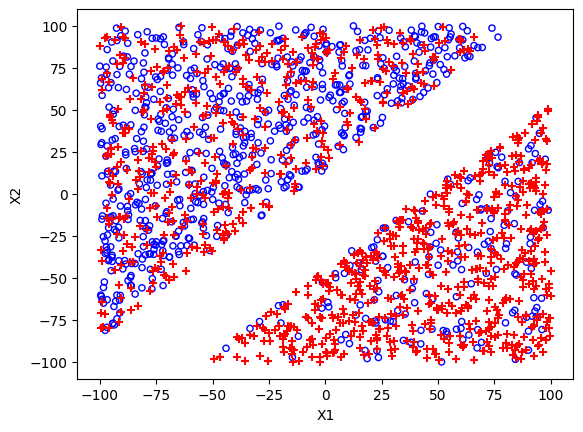

<ipython-input-101-86f25cac3856>:13: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_labeled[mask, 0], X_labeled[mask, 1], s=SIZE[label], facecolors=FACE[label], edgecolors=COLOR[label], marker=MARKER[label])


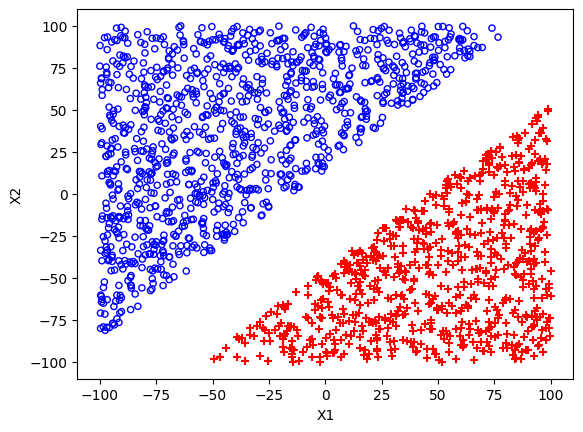

In [101]:
# Plotting and Accuracy for Method of Unbiased Estimators with Known Noise Rates
print(accuracy_score(y_labeled, y_pred))

for label in [-1, 1]:
    mask = (y_noisy == label)
    plt.scatter(X_labeled[mask, 0], X_labeled[mask, 1], s=SIZE[label], facecolors=FACE[label], edgecolors=COLOR[label], marker=MARKER[label])
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

for label in [-1, 1]:
    mask = (y_pred == label)
    plt.scatter(X_labeled[mask, 0], X_labeled[mask, 1], s=SIZE[label], facecolors=FACE[label], edgecolors=COLOR[label], marker=MARKER[label])
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [102]:
# Dataset Creation for UCI Banknote
df = pd.read_csv("data_banknote_authentication.txt", names=["variance", "skewness", "curtosis", "entropy", "class"])

df["class"] = df["class"].replace(0, -1)

X_labeled = df.iloc[:, :-1].to_numpy()
y_labeled = df.iloc[:, -1].to_numpy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [103]:
# Adding Noise to UCI Banknote Datset
rho_plus = 0.5
rho_minus = 0.1

y_noisy = np.copy(y_labeled)
for i in range(len(y_noisy)):
    if y_labeled[i] == 1:
        if np.random.random() < rho_plus:
            y_noisy[i] = -1
    elif y_labeled[i] == -1:
        if np.random.random() < rho_minus:
            y_noisy[i] = 1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:
# Implementation of Method of Unbiased Estimators with Known Noise Rates
def logistic_loss(t, y):
    return np.log(1 + np.exp(-t * y))

def unbiased_loss(t, y, rho_plus, rho_minus):
    rho_y = (y + 1) / 2 * (rho_plus - rho_minus) + rho_minus
    rho_minus_y = (y + 1) / 2 * (rho_minus - rho_plus) + rho_plus
    return ((1 - rho_minus_y) * logistic_loss(t, y) - rho_y * logistic_loss(t, -y)) / (1 - rho_plus - rho_minus)

def average_loss(params, X, y, rho_plus, rho_minus):
    t = np.dot(X, params)
    unbiased_losses = unbiased_loss(t, y, rho_plus, rho_minus)
    return np.mean(unbiased_losses)

def find_best_params(X, y, rho_plus, rho_minus):
    init_params = np.zeros(X.shape[1])
    result = minimize(average_loss, init_params, args=(X, y, rho_plus, rho_minus))
    return result.x

best_params = find_best_params(X_labeled, y_noisy, rho_plus, rho_minus)

<ipython-input-104-2480a469c966>:3: RuntimeWarning: overflow encountered in exp
  return np.log(1 + np.exp(-t * y))
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
<ipython-input-104-2480a469c966>:3: RuntimeWarning: overflow encountered in exp
  return np.log(1 + np.exp(-t * y))
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
<ipython-input-104-2480a469c966>:3: RuntimeWarning: overflow encountered in exp
  return np.log(1 + np.exp(-t * y))
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, ax

In [105]:
def predict(X, params):
    scores = np.dot(X, params)
    return np.sign(scores)

y_pred = predict(X_labeled, best_params)

print(accuracy_score(y_labeled, y_pred))

0.9533527696793003


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
# Implementation of Method of Unbiased Estimators with Unknown Noise Rates
warnings.filterwarnings("ignore")

def logistic_loss(t, y):
    return np.log(1 + np.exp(-t * y))

def unbiased_loss(t, y, rho_plus, rho_minus):
    rho_y = (y + 1) / 2 * (rho_plus - rho_minus) + rho_minus
    rho_minus_y = (y + 1) / 2 * (rho_minus - rho_plus) + rho_plus
    return ((1 - rho_minus_y) * logistic_loss(t, y) - rho_y * logistic_loss(t, -y)) / (1 - rho_plus - rho_minus)

def average_loss(params, X, y, rho_plus, rho_minus):
    t = np.dot(X, params)
    unbiased_losses = unbiased_loss(t, y, rho_plus, rho_minus)
    return np.mean(unbiased_losses)

def find_best_params(X, y, rho_plus, rho_minus):
    init_params = np.zeros(X.shape[1])
    result = minimize(average_loss, init_params, args=(X, y, rho_plus, rho_minus))
    return result.x

def single_fold(train_index, test_index, X, y, rho_plus, rho_minus):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    best_params = find_best_params(X_train, y_train, rho_plus, rho_minus)
    fold_loss = average_loss(best_params, X_train, y_train, rho_plus, rho_minus)
    return fold_loss

def k_fold_cross_validation(X, y, rho_plus, rho_minus, k=5):
    kf = KFold(n_splits=k)
    fold_results = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(single_fold, train_index, test_index, X, y, rho_plus, rho_minus)
                   for train_index, test_index in kf.split(X)]
        fold_results = [f.result() for f in futures]

    return np.mean(fold_results)

def optimize_rho(X, y, rho_values, k=5):
    best_rho_plus, best_rho_minus = None, None
    best_loss = np.inf
    
    for rho_plus in tqdm(rho_values, desc='Optimizing rho_plus'):
        for rho_minus in tqdm(rho_values, desc='Optimizing rho_minus', leave=False):
            if rho_plus + rho_minus >= 1:
                continue
            
            mean_loss = k_fold_cross_validation(X, y, rho_plus, rho_minus, k)
            if mean_loss < best_loss:
                best_loss = mean_loss
                best_rho_plus, best_rho_minus = rho_plus, rho_minus

    best_params = find_best_params(X, y, best_rho_plus, best_rho_minus)
    return best_rho_plus, best_rho_minus, best_loss, best_params

rho_values = np.linspace(0, 0.5, 11)  # Example: 11 values from 0 to 0.5

best_rho_plus, best_rho_minus, best_loss, best_params = optimize_rho(X_labeled, y_noisy, rho_values)
print("")
print("Best rho_plus:", best_rho_plus)
print("Best rho_minus:", best_rho_minus)
print("Best mean loss:", best_loss)
print("Best params:", best_params)
warnings.filterwarnings("default")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Optimizing rho_plus: 100%|██████████| 11/11 [02:14<00:00, 12.19s/it]


Best rho_plus: 0.45
Best rho_minus: 0.1
Best mean loss: 0.1653568395273728
Best params: [-1.68194587 -0.98163782 -1.07355471 -0.09751502]


In [107]:
def predict(X, params):
    scores = np.dot(X, params)
    return np.sign(scores)

y_pred = predict(X_labeled, best_params)

print(accuracy_score(y_labeled, y_pred))

0.9518950437317785


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [108]:
# Baseline using normal Logistic Regression
clf = LogisticRegression()
clf.fit(X_labeled, y_noisy)

y_pred = clf.predict(X_labeled)

acc = accuracy_score(y_labeled, y_pred)
print('Accuracy:', acc)

Accuracy: 0.7164723032069971


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [118]:
# Dataset Creation for UCI Heart
df = pd.read_csv("dataR2.csv")
df["Classification"] = df["Classification"].replace(2, -1)

X_labeled = df.iloc[:, :-1].to_numpy()
y_labeled = df.iloc[:, -1].to_numpy()

In [119]:
print(X_labeled)
scaler = MinMaxScaler()
X_labeled = scaler.fit_transform(X_labeled)
print(X_labeled)

[[ 48.          23.5         70.         ...   9.7024       7.99585
  417.114     ]
 [ 83.          20.69049454  92.         ...   5.429285     4.06405
  468.786     ]
 [ 82.          23.12467037  91.         ...  22.43204      9.27715
  554.697     ]
 ...
 [ 65.          32.05        97.         ...  22.54        10.33
  314.05      ]
 [ 72.          25.59        82.         ...  33.75         3.27
  392.46      ]
 [ 86.          27.18       138.         ...  14.11         4.35
   90.09      ]]
[[3.69230769e-01 2.53850329e-01 7.09219858e-02 ... 2.21151727e-01
  6.06648498e-02 2.24659127e-01]
 [9.07692308e-01 1.14826180e-01 2.26950355e-01 ... 1.03706769e-01
  1.08258334e-02 2.55926278e-01]
 [8.92307692e-01 2.35277707e-01 2.19858156e-01 ... 5.71021092e-01
  7.69064520e-02 3.07911729e-01]
 ...
 [6.30769231e-01 6.76934210e-01 2.62411348e-01 ... 5.73988332e-01
  9.02522500e-02 1.62294256e-01]
 [7.38461538e-01 3.57270833e-01 1.56028369e-01 ... 8.82090964e-01
  7.60552668e-04 2.09740790e-01]

In [126]:
# Adding Noise to UCI Heart Datset
rho_plus = 0.1
rho_minus = 0.4

y_noisy = np.copy(y_labeled)
for i in range(len(y_noisy)):
    if y_labeled[i] == 1:
        if np.random.random() < rho_plus:
            y_noisy[i] = -1
    elif y_labeled[i] == -1:
        if np.random.random() < rho_minus:
            y_noisy[i] = 1


In [127]:
# Implementation of Method of Unbiased Estimators with Known Noise Rates
def logistic_loss(t, y):
    return np.log(1 + np.exp(-t * y))

def unbiased_loss(t, y, rho_plus, rho_minus):
    rho_y = (y + 1) / 2 * (rho_plus - rho_minus) + rho_minus
    rho_minus_y = (y + 1) / 2 * (rho_minus - rho_plus) + rho_plus
    return ((1 - rho_minus_y) * logistic_loss(t, y) - rho_y * logistic_loss(t, -y)) / (1 - rho_plus - rho_minus)

def average_loss(params, X, y, rho_plus, rho_minus):
    t = np.dot(X, params)
    unbiased_losses = unbiased_loss(t, y, rho_plus, rho_minus)
    return np.mean(unbiased_losses)

def find_best_params(X, y, rho_plus, rho_minus):
    init_params = np.zeros(X.shape[1])
    result = minimize(average_loss, init_params, args=(X, y, rho_plus, rho_minus))
    return result.x

best_params = find_best_params(X_labeled, y_noisy, rho_plus, rho_minus)

<ipython-input-127-2480a469c966>:3: RuntimeWarning: overflow encountered in exp
  return np.log(1 + np.exp(-t * y))
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
<ipython-input-127-2480a469c966>:3: RuntimeWarning: overflow encountered in exp
  return np.log(1 + np.exp(-t * y))
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
<ipython-input-127-2480a469c966>:3: RuntimeWarning: overflow encountered in exp
  return np.log(1 + np.exp(-t * y)

In [128]:
def predict(X, params):
    scores = np.dot(X, params)
    return np.sign(scores)

y_pred = predict(X_labeled, best_params)

print(accuracy_score(y_labeled, y_pred))

0.6896551724137931


In [131]:
# Implementation of Method of Unbiased Estimators with Unknown Noise Rates
warnings.filterwarnings("ignore")

def logistic_loss(t, y):
    return np.log(1 + np.exp(-t * y))

def unbiased_loss(t, y, rho_plus, rho_minus):
    rho_y = (y + 1) / 2 * (rho_plus - rho_minus) + rho_minus
    rho_minus_y = (y + 1) / 2 * (rho_minus - rho_plus) + rho_plus
    return ((1 - rho_minus_y) * logistic_loss(t, y) - rho_y * logistic_loss(t, -y)) / (1 - rho_plus - rho_minus)

def average_loss(params, X, y, rho_plus, rho_minus):
    t = np.dot(X, params)
    unbiased_losses = unbiased_loss(t, y, rho_plus, rho_minus)
    return np.mean(unbiased_losses)

def find_best_params(X, y, rho_plus, rho_minus):
    init_params = np.zeros(X.shape[1])
    result = minimize(average_loss, init_params, args=(X, y, rho_plus, rho_minus))
    return result.x

def single_fold(train_index, test_index, X, y, rho_plus, rho_minus):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    best_params = find_best_params(X_train, y_train, rho_plus, rho_minus)
    fold_loss = average_loss(best_params, X_train, y_train, rho_plus, rho_minus)
    return fold_loss

def k_fold_cross_validation(X, y, rho_plus, rho_minus, k=5):
    kf = KFold(n_splits=k)
    fold_results = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(single_fold, train_index, test_index, X, y, rho_plus, rho_minus)
                   for train_index, test_index in kf.split(X)]
        fold_results = [f.result() for f in futures]

    return np.mean(fold_results)

def optimize_rho(X, y, rho_values, k=5):
    best_rho_plus, best_rho_minus = None, None
    best_loss = np.inf
    
    for rho_plus in tqdm(rho_values, desc='Optimizing rho_plus'):
        for rho_minus in tqdm(rho_values, desc='Optimizing rho_minus', leave=False):
            if rho_plus + rho_minus >= 1:
                continue
            
            mean_loss = k_fold_cross_validation(X, y, rho_plus, rho_minus, k)
            if mean_loss < best_loss:
                best_loss = mean_loss
                best_rho_plus, best_rho_minus = rho_plus, rho_minus

    best_params = find_best_params(X, y, best_rho_plus, best_rho_minus)
    return best_rho_plus, best_rho_minus, best_loss, best_params

rho_values = np.linspace(0, 0.5, 11)  # Example: 11 values from 0 to 0.5

best_rho_plus, best_rho_minus, best_loss, best_params = optimize_rho(X_labeled, y_noisy, rho_values)
print("")
print("Best rho_plus:", best_rho_plus)
print("Best rho_minus:", best_rho_minus)
print("Best mean loss:", best_loss)
print("Best params:", best_params)
warnings.filterwarnings("default")

Optimizing rho_plus: 100%|██████████| 11/11 [02:35<00:00, 14.16s/it]


Best rho_plus: 0.0
Best rho_minus: 0.35000000000000003
Best mean loss: -0.04484899836527876
Best params: [ 2.78071357e-01 -2.22134119e+00  2.87601691e+00  2.40689972e+02
 -4.51648773e+02  6.68442848e+00 -1.80803894e+00  6.38543821e-01
 -2.97872931e-01]


In [132]:
def predict(X, params):
    scores = np.dot(X, params)
    return np.sign(scores)

y_pred = predict(X_labeled, best_params)

print(accuracy_score(y_labeled, y_pred))

0.7155172413793104


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [130]:
# Baseline using normal Logistic Regression
clf = LogisticRegression()
clf.fit(X_labeled, y_noisy)

y_pred = clf.predict(X_labeled)

acc = accuracy_score(y_labeled, y_pred)
print('Accuracy:', acc)

Accuracy: 0.5258620689655172
